In [0]:
import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib import font_manager, rc
%matplotlib inline

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

import warnings
warnings.filterwarnings('ignore')

sns.set_palette('pastel')
matplotlib.rcParams['axes.unicode_minus'] = False
plt.rc('font',  family='malgun gothic')

In [1]:
online_sales = pd.read_csv('./dataset/Onlinesales_info.csv')
customers_data = pd.read_csv('./dataset/Customer_info.csv')
discount_coupon = pd.read_csv('./dataset/Discount_info.csv')
marketing_spend = pd.read_csv('./dataset/Marketing_info.csv')
tax_amount = pd.read_csv('./dataset/Tax_info.csv')

In [2]:
def transform_month(month):
    month_mapping = {
        'Jan': '2019-01',
        'Feb': '2019-02',
        'Mar': '2019-03',
        'Apr': '2019-04',
        'May': '2019-05',
        'Jun': '2019-06',
        'Jul': '2019-07',
        'Aug': '2019-08',
        'Sep': '2019-09',
        'Oct': '2019-10',
        'Nov': '2019-11',
        'Dec': '2019-12'
    }
    
    return month_mapping[month]

discount_coupon['월'] = discount_coupon['월'].map(transform_month)
discount_coupon

,월,제품카테고리,쿠폰코드,할인율
0,2019-01,Apparel,SALE10,10
1,2019-02,Apparel,SALE20,20
2,2019-03,Apparel,SALE30,30
3,2019-01,Nest-USA,ELEC10,10
4,2019-02,Nest-USA,ELEC20,20
...,...,...,...,...
199,2019-11,Notebooks & Journals,NJ20,20
200,2019-12,Notebooks & Journals,NJ30,30
201,2019-10,Android,AND10,10
202,2019-11,Android,AND20,20


In [3]:
df = online_sales.merge(customers_data, on = '고객ID', how = 'left').assign(월 = pd.to_datetime(online_sales['거래날짜']).dt.to_period('M').astype('str')).merge(discount_coupon, on = ['월', '제품카테고리'], how = 'left').merge(tax_amount, on = '제품카테고리', how = 'left')
df.head()

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,고객지역,가입기간,월,쿠폰코드,할인율,GST
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,남,Chicago,12,2019-01,ELEC10,10.0,0.10
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,남,Chicago,12,2019-01,ELEC10,10.0,0.10
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.5,Used,남,Chicago,12,2019-01,OFF10,10.0,0.10
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,6.5,Not Used,남,Chicago,12,2019-01,SALE10,10.0,0.18
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,6.5,Used,남,Chicago,12,2019-01,AIO10,10.0,0.18


In [4]:
df['거래날짜'] = pd.to_datetime(df['거래날짜'])

In [5]:
df['쿠폰코드'].fillna('unknown', inplace=True)
df['할인율'].fillna(0, inplace=True)

In [6]:
df['전체금액'] = df['수량'] * df['평균금액']

def total(data):
    price = data['전체금액']
    gst = data['GST']
    
    discount_rate = data['할인율'] if data['쿠폰상태'] == 'Used' else 0
    subtotal = price*(1-discount_rate/100)
    total = subtotal + (subtotal * gst)
    return total

df['지불금액'] = df.apply(total, axis = 1) # 배송료 제외 지불금액

In [7]:
if df.groupby('거래ID')['배송료'].nunique().value_counts().values[0] == df.거래ID.nunique():
    print('각 거래마다 배송료는 한번씩 청구됨') 

각 거래마다 배송료는 한번씩 청구됨


In [8]:
first_delivery_fee_by_customer = df.groupby(['고객ID', '거래ID']).first()['배송료']

customer_delivery_fee_sum = first_delivery_fee_by_customer.groupby('고객ID').sum()
customer_delivery_fee_sum

고객ID
USER_0000     75.00
USER_0001    286.46
USER_0002     81.07
USER_0003     82.39
USER_0004    154.49
              ...  
USER_1463     94.35
USER_1464    222.05
USER_1465     12.50
USER_1466      6.00
USER_1467    337.87
Name: 배송료, Length: 1468, dtype: float64

In [9]:
last = df['거래날짜'].max() + pd.DateOffset(days = 1)
rfm_df = df.groupby(['고객ID']).agg({'거래날짜':lambda x : (last - x.max()).days,
                                     '거래ID' : lambda x : x.nunique(),
                                     '지불금액' : 'sum'})

rfm_df.rename(columns = {'거래날짜' : 'Recency',
                         '거래ID' : 'Frequency',
                         '지불금액' : 'Monetary'}, inplace = True)

rfm_df.reset_index(inplace = True)
rfm_df.head()


,고객ID,Recency,Frequency,Monetary
0,USER_0000,108,1,24.98174
1,USER_0001,60,31,15021.70396
2,USER_0002,74,8,1492.40594
3,USER_0003,18,11,1339.55528
4,USER_0004,108,13,1369.93900


In [10]:
rfm_df['Monetary'] = rfm_df['Monetary'].values + customer_delivery_fee_sum.values
rfm_df

,고객ID,Recency,Frequency,Monetary
0,USER_0000,108,1,99.98174
1,USER_0001,60,31,15308.16396
2,USER_0002,74,8,1573.47594
3,USER_0003,18,11,1421.94528
4,USER_0004,108,13,1524.42900
...,...,...,...,...
1463,USER_1463,271,3,676.70600
1464,USER_1464,88,19,2606.17372
1465,USER_1465,195,2,127.90750
1466,USER_1466,70,1,333.80000


In [11]:
df = df.merge(rfm_df, on = '고객ID')

<Axes: xlabel='Recency', ylabel='Count'>

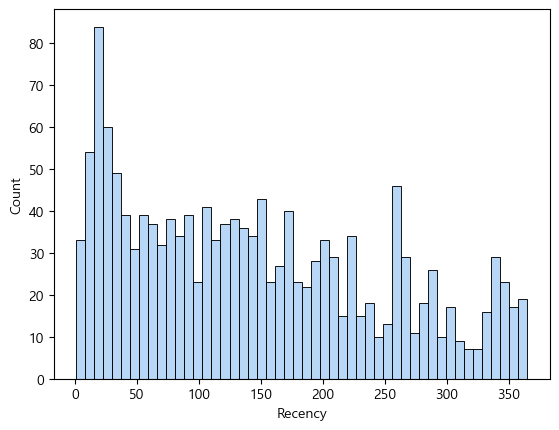

In [12]:
sns.histplot(rfm_df['Recency'], bins = 50)

군집은 내스탈대로

In [13]:
def label_r(recency):
    if recency <= 50:
        return 5
    elif recency <= 100:
        return 4
    elif recency <= 150:
        return 3
    elif recency <= 200:
        return 2
    elif recency <= 250:
        return 1
    else:
        return 0
    
df['R'] = df['Recency'].apply(label_r)

코호트


In [14]:
df['월'] = pd.to_datetime(df['월'])
df

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,...,월,쿠폰코드,할인율,GST,전체금액,지불금액,Recency,Frequency,Monetary,R
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,...,2019-01-01,ELEC10,10.0,0.10,153.71,152.17290,340,177,39126.79564,0
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,...,2019-01-01,ELEC10,10.0,0.10,153.71,152.17290,340,177,39126.79564,0
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.50,Used,남,...,2019-01-01,OFF10,10.0,0.10,2.05,2.02950,340,177,39126.79564,0
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,6.50,Not Used,남,...,2019-01-01,SALE10,10.0,0.18,87.65,103.42700,340,177,39126.79564,0
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,6.50,Used,남,...,2019-01-01,AIO10,10.0,0.18,16.50,17.52300,340,177,39126.79564,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52919,USER_0504,Transaction_25056,2019-12-31,Product_0976,Nest-USA,1,121.30,6.50,Clicked,여,...,2019-12-01,ELEC30,30.0,0.10,121.30,133.43000,1,6,1170.13702,5
52920,USER_0504,Transaction_25057,2019-12-31,Product_0413,Apparel,1,48.92,6.50,Used,여,...,2019-12-01,SALE30,30.0,0.18,48.92,40.40792,1,6,1170.13702,5
52921,USER_0504,Transaction_25058,2019-12-31,Product_0989,Nest-USA,1,151.88,6.50,Used,여,...,2019-12-01,ELEC30,30.0,0.10,151.88,116.94760,1,6,1170.13702,5
52922,USER_0562,Transaction_25059,2019-12-31,Product_0985,Nest-USA,5,80.52,6.50,Clicked,여,...,2019-12-01,ELEC30,30.0,0.10,402.60,442.86000,1,2,823.63800,5


In [15]:
grouping = df.groupby('고객ID')['월']
df['최초거래월'] = grouping.transform('min')

In [16]:
df = df.rename(columns = {'월' : '거래월'})
df['경과일'] = (df['거래월'] - df['최초거래월'])//30
df

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,...,할인율,GST,전체금액,지불금액,Recency,Frequency,Monetary,R,최초거래월,경과일
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,...,10.0,0.10,153.71,152.17290,340,177,39126.79564,0,2019-01-01,0 days
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,...,10.0,0.10,153.71,152.17290,340,177,39126.79564,0,2019-01-01,0 days
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.50,Used,남,...,10.0,0.10,2.05,2.02950,340,177,39126.79564,0,2019-01-01,0 days
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,6.50,Not Used,남,...,10.0,0.18,87.65,103.42700,340,177,39126.79564,0,2019-01-01,0 days
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,6.50,Used,남,...,10.0,0.18,16.50,17.52300,340,177,39126.79564,0,2019-01-01,0 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52919,USER_0504,Transaction_25056,2019-12-31,Product_0976,Nest-USA,1,121.30,6.50,Clicked,여,...,30.0,0.10,121.30,133.43000,1,6,1170.13702,5,2019-12-01,0 days
52920,USER_0504,Transaction_25057,2019-12-31,Product_0413,Apparel,1,48.92,6.50,Used,여,...,30.0,0.18,48.92,40.40792,1,6,1170.13702,5,2019-12-01,0 days
52921,USER_0504,Transaction_25058,2019-12-31,Product_0989,Nest-USA,1,151.88,6.50,Used,여,...,30.0,0.10,151.88,116.94760,1,6,1170.13702,5,2019-12-01,0 days
52922,USER_0562,Transaction_25059,2019-12-31,Product_0985,Nest-USA,5,80.52,6.50,Clicked,여,...,30.0,0.10,402.60,442.86000,1,2,823.63800,5,2019-12-01,0 days


In [17]:
for x in range(1, 13):
    idx = df[(df.경과일 < dt.timedelta(days = x)) & (df.경과일 >= dt.timedelta(days = x-1))].index
    df.loc[idx, '경과월'] = x-1

In [25]:
df[['최초거래월', '거래날짜', '경과월']].sample(10)

,최초거래월,거래날짜,경과월
43050,2019-08-01,2019-08-15,0.0
22932,2019-03-01,2019-03-24,0.0
21715,2019-03-01,2019-10-30,7.0
21675,2019-03-01,2019-05-23,2.0
26716,2019-04-01,2019-11-04,7.0
7240,2019-01-01,2019-01-17,0.0
43482,2019-08-01,2019-08-19,0.0
42162,2019-08-01,2019-11-22,3.0
32748,2019-05-01,2019-09-24,4.0
21514,2019-03-01,2019-07-22,4.0


문제 : 가입일을 어떻게 볼 것인가?  
가입시기는 모두 동일한 값을 가진다  
1. 거래 최초일로부터의 가입시기는 아니다  
2. 거래 마지막일로부터의 가입시기라면 유저마다 기준점이 다르기 때문에 명확하지 않다  
3. 이 데이터의 마지막시점이 19년 12월 31일 이므로 현 시점을 20년 01월 01일로 잡는다면 동일한 기준으로 가입일 계산 가능 

In [19]:
df['가입년월'] = pd.to_datetime('2020-01-01') - df['가입기간'].apply(lambda x: pd.DateOffset(months=x))
df.query("`고객ID` == 'USER_0118'")

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,...,전체금액,지불금액,Recency,Frequency,Monetary,R,최초거래월,경과일,경과월,가입년월
2947,USER_0118,Transaction_0536,2019-01-08,Product_0201,Apparel,3,14.02,62.74,Used,여,...,42.06,44.66772,108,328,82405.31626,3,2019-01-01,0 days 00:00:00,0.0,2017-09-01 00:00:00
2948,USER_0118,Transaction_1339,2019-01-20,Product_0981,Nest-USA,1,153.71,6.50,Used,여,...,153.71,152.17290,108,328,82405.31626,3,2019-01-01,0 days 00:00:00,0.0,2017-09-01 00:00:00
2949,USER_0118,Transaction_3192,2019-02-18,Product_0976,Nest-USA,2,119.00,6.50,Clicked,여,...,238.00,261.80000,108,328,82405.31626,3,2019-01-01,1 days 00:48:00,1.0,2017-09-01 00:00:00
2950,USER_0118,Transaction_3193,2019-02-18,Product_0976,Nest-USA,2,119.00,6.50,Used,여,...,238.00,209.44000,108,328,82405.31626,3,2019-01-01,1 days 00:48:00,1.0,2017-09-01 00:00:00
2951,USER_0118,Transaction_3194,2019-02-18,Product_0976,Nest-USA,1,119.00,6.50,Clicked,여,...,119.00,130.90000,108,328,82405.31626,3,2019-01-01,1 days 00:48:00,1.0,2017-09-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3637,USER_0118,Transaction_16284,2019-09-05,Product_0984,Nest-USA,1,79.00,6.00,Used,여,...,79.00,60.83000,108,328,82405.31626,3,2019-01-01,8 days 02:24:00,8.0,2017-09-01 00:00:00
3638,USER_0118,Transaction_16900,2019-09-15,Product_0117,Apparel,1,39.19,75.00,Used,여,...,39.19,32.37094,108,328,82405.31626,3,2019-01-01,8 days 02:24:00,8.0,2017-09-01 00:00:00
3639,USER_0118,Transaction_16900,2019-09-15,Product_0286,Apparel,1,16.99,75.00,Used,여,...,16.99,14.03374,108,328,82405.31626,3,2019-01-01,8 days 02:24:00,8.0,2017-09-01 00:00:00
3640,USER_0118,Transaction_16900,2019-09-15,Product_0942,Office,1,2.50,75.00,Clicked,여,...,2.50,2.75000,108,328,82405.31626,3,2019-01-01,8 days 02:24:00,8.0,2017-09-01 00:00:00


In [20]:
df.loc[pd.to_datetime(df['가입년월']).dt.year == 2019, '고객유형'] = '신규고객'
df.loc[pd.to_datetime(df['가입년월']).dt.year != 2019, '고객유형'] = '기존고객'

df

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,...,지불금액,Recency,Frequency,Monetary,R,최초거래월,경과일,경과월,가입년월,고객유형
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,...,152.17290,340,177,39126.79564,0,2019-01-01,0 days,0.0,2019-01-01 00:00:00,신규고객
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,...,152.17290,340,177,39126.79564,0,2019-01-01,0 days,0.0,2019-01-01 00:00:00,신규고객
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.50,Used,남,...,2.02950,340,177,39126.79564,0,2019-01-01,0 days,0.0,2019-01-01 00:00:00,신규고객
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,6.50,Not Used,남,...,103.42700,340,177,39126.79564,0,2019-01-01,0 days,0.0,2019-01-01 00:00:00,신규고객
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,6.50,Used,남,...,17.52300,340,177,39126.79564,0,2019-01-01,0 days,0.0,2019-01-01 00:00:00,신규고객
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52919,USER_0504,Transaction_25056,2019-12-31,Product_0976,Nest-USA,1,121.30,6.50,Clicked,여,...,133.43000,1,6,1170.13702,5,2019-12-01,0 days,0.0,2016-04-01 00:00:00,기존고객
52920,USER_0504,Transaction_25057,2019-12-31,Product_0413,Apparel,1,48.92,6.50,Used,여,...,40.40792,1,6,1170.13702,5,2019-12-01,0 days,0.0,2016-04-01 00:00:00,기존고객
52921,USER_0504,Transaction_25058,2019-12-31,Product_0989,Nest-USA,1,151.88,6.50,Used,여,...,116.94760,1,6,1170.13702,5,2019-12-01,0 days,0.0,2016-04-01 00:00:00,기존고객
52922,USER_0562,Transaction_25059,2019-12-31,Product_0985,Nest-USA,5,80.52,6.50,Clicked,여,...,442.86000,1,2,823.63800,5,2019-12-01,0 days,0.0,2019-06-01 00:00:00,신규고객


In [44]:
cohort_first_buy_month = df.merge(df.groupby('고객ID')['거래날짜'].min().reset_index(), on = '고객ID').rename(columns = {'거래날짜_x' : '거래날짜','거래날짜_y' : '첫거래일'})
cohort_first_buy_month = cohort_first_buy_month.assign(month_f = pd.to_datetime(cohort_first_buy_month['첫거래일']).dt.to_period('M').astype('str'), month_n = pd.to_datetime(cohort_first_buy_month['거래날짜']).dt.to_period('M').astype('str'))
cohort_first_buy_month.head(10)

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,...,Monetary,R,최초거래월,경과일,경과월,가입년월,고객유형,첫거래일,month_f,month_n
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,남,...,39126.79564,0,2019-01-01,0 days,0.0,2019-01-01 00:00:00,신규고객,2019-01-01,2019-01,2019-01
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,남,...,39126.79564,0,2019-01-01,0 days,0.0,2019-01-01 00:00:00,신규고객,2019-01-01,2019-01,2019-01
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.5,Used,남,...,39126.79564,0,2019-01-01,0 days,0.0,2019-01-01 00:00:00,신규고객,2019-01-01,2019-01,2019-01
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,6.5,Not Used,남,...,39126.79564,0,2019-01-01,0 days,0.0,2019-01-01 00:00:00,신규고객,2019-01-01,2019-01,2019-01
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,6.5,Used,남,...,39126.79564,0,2019-01-01,0 days,0.0,2019-01-01 00:00:00,신규고객,2019-01-01,2019-01,2019-01
5,USER_1358,Transaction_0003,2019-01-01,Product_0854,Bags,15,5.15,6.5,Used,남,...,39126.79564,0,2019-01-01,0 days,0.0,2019-01-01 00:00:00,신규고객,2019-01-01,2019-01,2019-01
6,USER_1358,Transaction_0003,2019-01-01,Product_0880,Drinkware,15,3.08,6.5,Not Used,남,...,39126.79564,0,2019-01-01,0 days,0.0,2019-01-01 00:00:00,신규고객,2019-01-01,2019-01,2019-01
7,USER_1358,Transaction_0003,2019-01-01,Product_0885,Drinkware,15,10.31,6.5,Clicked,남,...,39126.79564,0,2019-01-01,0 days,0.0,2019-01-01 00:00:00,신규고객,2019-01-01,2019-01,2019-01
8,USER_1358,Transaction_0003,2019-01-01,Product_0898,Drinkware,5,9.27,6.5,Used,남,...,39126.79564,0,2019-01-01,0 days,0.0,2019-01-01 00:00:00,신규고객,2019-01-01,2019-01,2019-01
9,USER_1358,Transaction_0013,2019-01-01,Product_0973,Lifestyle,1,1.24,6.5,Used,남,...,39126.79564,0,2019-01-01,0 days,0.0,2019-01-01 00:00:00,신규고객,2019-01-01,2019-01,2019-01


In [50]:
cohort_first_buy_month['경과월'] = cohort_first_buy_month.month_n.str[5:].astype('int') - cohort_first_buy_month.month_f.str[5:].astype('int')

In [60]:
def cohort_chart(data, title = '코호트'):
    cohort_data = data.groupby(['최초거래월', '경과월'])['고객ID'].nunique().reset_index()
    # grouping = df.groupby(['최초거래월', '경과월'])
    # cohort_data = grouping['고객ID'].apply(pd.Series.nunique).reset_index()
    cohort_counts = cohort_data.pivot(index = '최초거래월', columns = '경과월', values = '고객ID')

    cohort_size = cohort_counts.iloc[:,0]
    retention = cohort_counts.divide(cohort_size, axis = 0)
    # retention.round(3) * 100

    plt.figure(figsize = (9, 6))
    plt.title(title)
    ax = sns.heatmap(data = retention, annot = True, fmt = '.0%', vmin = 0.0, vmax = 0.5, cmap = 'Blues')
    # ax.set_yticklabels([f'{int(label.get_text())}월' for label in ax.get_yticklabels()], rotation=0)
    ax.set_yticklabels([f'19년 {label.get_text().split("-")[1]}월' for label in ax.get_yticklabels()], rotation=0)
    plt.show()

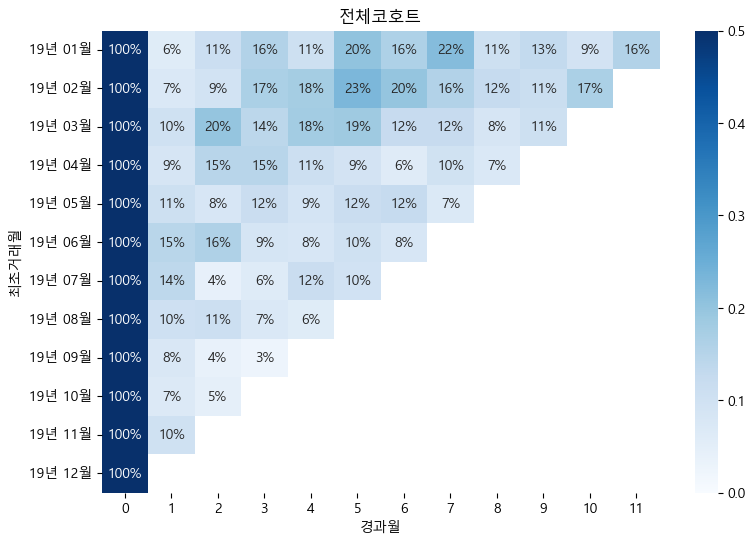

In [62]:
cohort_chart(cohort_first_buy_month, title = '전체코호트')

### 타깃 코호트 리텐션 확인  
타깃 : nest 제품군 구입 유저  
타깃리텐션의 경우 전체 리텐션 보다 떨어지는 경향을 보여주는데, 이는 nest 제품군의 평균 사용수명이 년단위로 되어있기 때문에 한번 구매 후  
동일 nest 제품을 구매하기 위해 걸리는 시간이 오래 걸릴 수 밖에 없음.


In [65]:
nest = ['Nest', 'Nest-USA', 'Nest-Canada']


targetidx = cohort_first_buy_month[cohort_first_buy_month.제품카테고리.isin(nest)].index

target_user = cohort_first_buy_month[cohort_first_buy_month.index.isin(targetidx)]
nontarget_user = cohort_first_buy_month[~cohort_first_buy_month.index.isin(targetidx)]

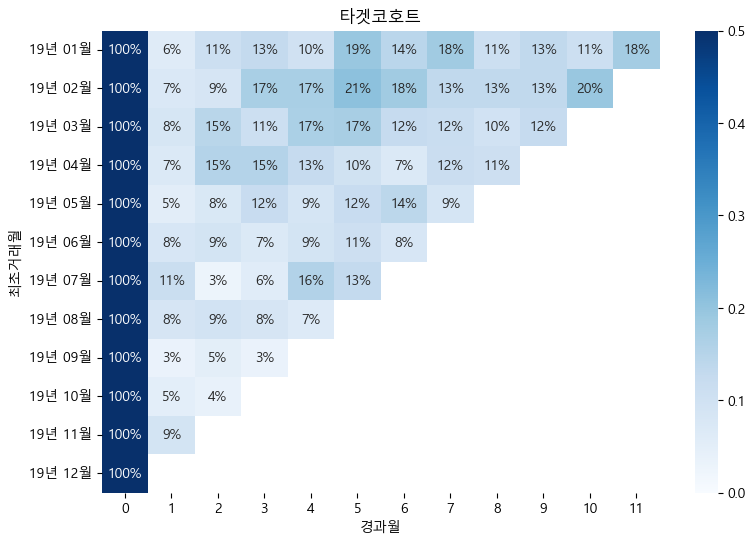

In [66]:
cohort_chart(target_user, title = '타겟코호트')

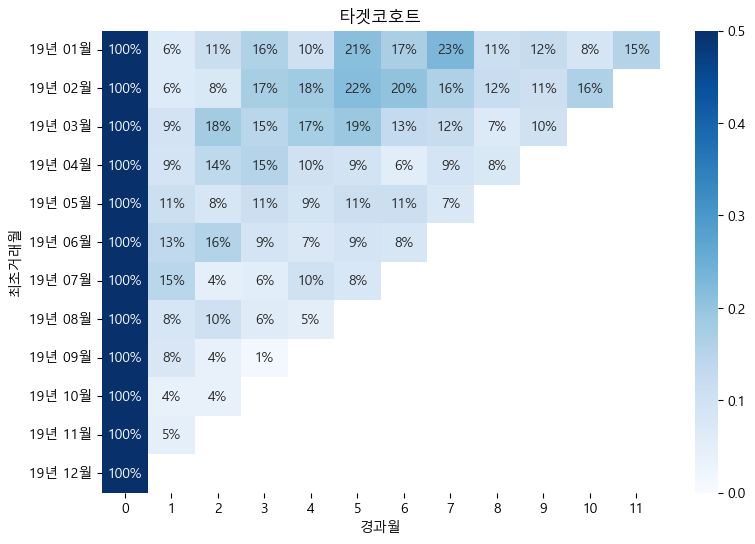

In [67]:
cohort_chart(nontarget_user, title = '타겟코호트')

In [68]:
nest = ['Nest']


targetidx = cohort_first_buy_month[cohort_first_buy_month.제품카테고리.isin(nest)].index

target_user = cohort_first_buy_month[cohort_first_buy_month.index.isin(targetidx)]
nontarget_user = cohort_first_buy_month[~cohort_first_buy_month.index.isin(targetidx)]

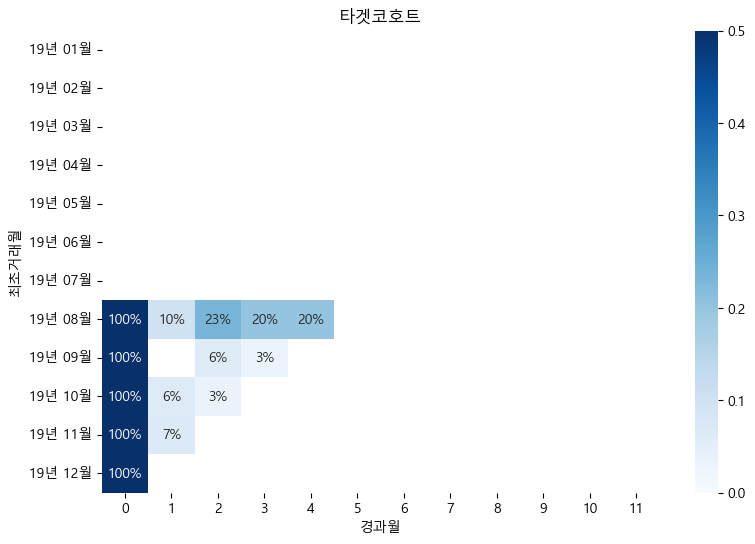

In [69]:
cohort_chart(target_user, title = '타겟코호트')

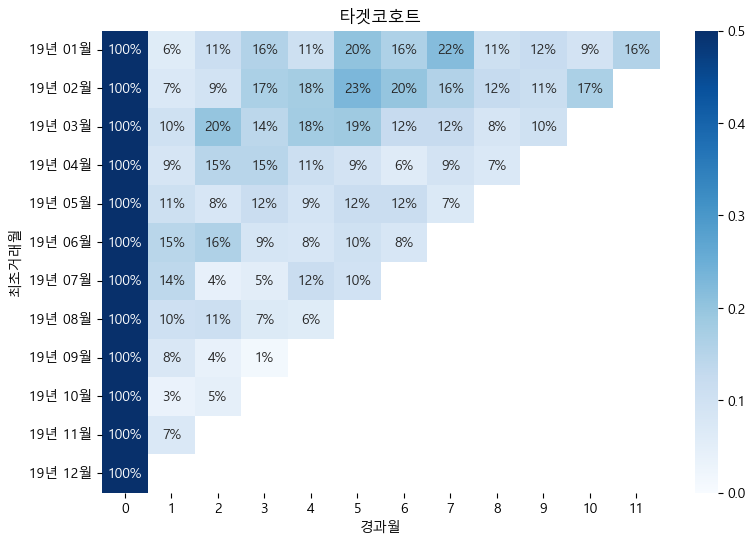

In [70]:
cohort_chart(nontarget_user, title = '타겟코호트')